# 1. Generate Image Symbolic Representation Data

In [29]:
import blosc
from collections import defaultdict
import io
import os
import pickle as pkl
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!ls ../../data/babyai_pretraining

BabyAI-BossLevel-Small-v0.pkl	       BabyAI-BossLevel-v0-split-9.pkl
BabyAI-BossLevel-Small-v0_valid.pkl    BabyAI-BossLevel-v0-split-9_valid.pkl
BabyAI-BossLevel-v0.pkl		       BabyAI-GoToLocal-v0.pkl
BabyAI-BossLevel-v0-split-0.pkl        BabyAI-GoToLocal-v0_valid.pkl
BabyAI-BossLevel-v0-split-0_valid.pkl  BabyAI-GoToObjMaze-v0.pkl
BabyAI-BossLevel-v0-split-1.pkl        BabyAI-GoToObj-v0.pkl
BabyAI-BossLevel-v0-split-1_valid.pkl  BabyAI-GoToObj-v0-split-1.pkl
BabyAI-BossLevel-v0-split-2.pkl        BabyAI-GoToObj-v0_valid.pkl
BabyAI-BossLevel-v0-split-2_valid.pkl  BabyAI-GoToRedBallGrey-v0.pkl
BabyAI-BossLevel-v0-split-3.pkl        BabyAI-GoToRedBallGrey-v0_valid.pkl
BabyAI-BossLevel-v0-split-3_valid.pkl  BabyAI-GoToRedBall-v0.pkl
BabyAI-BossLevel-v0-split-4.pkl        BabyAI-GoToRedBall-v0_valid.pkl
BabyAI-BossLevel-v0-split-4_valid.pkl  BabyAI-GoTo-v0.pkl
BabyAI-BossLevel-v0-split-5.pkl        BabyAI-PickupLoc-v0.pkl
BabyAI-BossLevel-v0-split-5_valid.pkl  BabyAI-PickupLoc-v0_valid.p

In [ ]:
# No split size
def get_pretraining_data(
    env,
    data,
    output_dir_path,
    is_train,
    split_id,
):
    def image_to_bytes(image):
        bytes_io = io.BytesIO()
        image.save(bytes_io, "PNG")
        return bytes_io.getvalue()
    
    def get_image_symbolic_repr(image):
        height, width, channel = image.shape
        img_symbolic = np.zeros((height, width))
        for h in range(height):
            for w in range(width):
                element = image[h][w]
                img_symbolic[h][w] = SYMBOL_TO_IDX[tuple(element)]
        return img_symbolic
    
    
    
    output_dir = os.path.join(output_dir_path, env)
    os.makedirs(output_dir, exist_ok=True)
    
    data_split = []
    for ex_id, ex in tqdm(enumerate(data), total=len(data)):
        img_rgb = blosc.unpack_array(ex[2])
        img_rgb = Image.fromarray(img_rgb[0])  # Always select the first frame
        img_raw = blosc.unpack_array(ex[3])
        img_raw = Image.fromarray(img_raw[0])  # Always select the first frame
        img_symbolic_repr = get_image_symbolic_repr(img_raw)
        text_symbolic_repr = get_text_symbolic_repr(img_raw)
        
        img_rgb_encoded = image_to_bytes(img_rgb)
        
        action = ",".join(ex[6])
        
        data_split.append({
            "img_rgb": img_rgb_encoded,
            "img_symbolic_repr": img_symbolic_repr,
            "text_symbolic_repr": text_symbolic_repr,
            "mission": ex[0],
            "action_seq": action
        })
    
    if data_split:
        if is_train:
            output_name = f"split_train_{split_id}"
        else:
            output_name = f"split_valid_{split_id}"

        output_path = os.path.join(output_dir, f"{output_name}.pkl")
        with open(output_path, "wb") as f:
            pkl.dump(data_split, f)


In [26]:
# [object, color, state]
COLOR_TO_IDX = {
    'red'   : 0,
    'green' : 1,
    'blue'  : 2,
    'purple': 3,
    'yellow': 4,
    'grey'  : 5
}

OBJECT_TO_IDX = {
    'unseen'        : 0,
    'empty'         : 1,
    'wall'          : 2,
    'floor'         : 3,
    'door'          : 4,
    'key'           : 5,
    'ball'          : 6,
    'box'           : 7,
    'goal'          : 8,
    'lava'          : 9,
    'agent'         : 10,
}

STATE_TO_IDX = {
    'open'  : 0,
    'closed': 1,
    'locked': 2,
}

IDX_TO_COLOR = {idx:color for color, idx in COLOR_TO_IDX.items()}
IDX_TO_OBJECT = {idx:obj for obj, idx in OBJECT_TO_IDX.items()}
IDX_TO_STATE = {idx:state for state, idx in STATE_TO_IDX.items()}

# Get all the symbols
SYMBOL_TO_IDX = {}
for color, color_id in COLOR_TO_IDX.items():
    for obj, obj_id in OBJECT_TO_IDX.items():
        for state, state_id in STATE_TO_IDX.items():
            SYMBOL_TO_IDX[(obj_id, color_id, state_id)] = len(SYMBOL_TO_IDX)

IDX_TO_SYMBOL = {idx:symbol for symbol, idx in SYMBOL_TO_IDX.items()}

In [2]:
for split_id in range(10):
    with open(f"../../data/babyai_pretraining/BabyAI-BossLevel-v0-split-{split_id}.pkl", "rb") as f:
        demos = pkl.load(f)
    break

In [38]:
for row_id in tqdm(range(len(demos))):
    demo = demos[row_id]
    mission = demo[0]
    img = blosc.unpack_array(demo[2])[0]
    img_raw = blosc.unpack_array(demo[3])
    img_raw = img_raw[0]
    break

  0%|                                                 | 0/10000 [00:00<?, ?it/s]


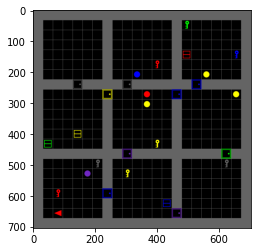

In [39]:
plt.imshow(img)

In [33]:
height, width, channel = img_raw.shape

img_symbolic = np.zeros((height, width))
for h in range(height):
    for w in range(width):
        element = img_raw[h][w]
        img_symbolic[h][w] = SYMBOL_TO_IDX[tuple(element)]